In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import os

In [4]:
# combine features + target
df = X.copy()
df["target"] = y

print("Shape:", df.shape)
df.head()

Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [6]:
# STEP 2: Handle missing values
print("Missing values per column:\n", df.isnull().sum())
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64
Numeric columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Categorical columns: []


In [7]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
df[num_cols] = imputer.fit_transform(df[num_cols])
print("Missing values after imputation:\n", df.isnull().sum())


Missing values after imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [9]:
# step 3 encoding :
from sklearn.preprocessing import OneHotEncoder


categorical_like = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

encoder = OneHotEncoder(sparse_output=False, drop="first")  
encoded = encoder.fit_transform(df[categorical_like])

# put back into dataframe
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_like))
df_encoded = pd.concat([df.drop(columns=categorical_like), encoded_df], axis=1)

print("Shape after encoding:", df_encoded.shape)
df_encoded.head()


Shape after encoding: (303, 19)


,age,trestbps,chol,thalach,oldpeak,ca,target,sex_1.0,cp_2.0,cp_3.0,cp_4.0,fbs_1.0,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,thal_6.0,thal_7.0
0,63.0,145.0,233.0,150.0,2.3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,67.0,160.0,286.0,108.0,1.5,3.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2,67.0,120.0,229.0,129.0,2.6,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,37.0,130.0,250.0,187.0,3.5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,41.0,130.0,204.0,172.0,1.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# step 4 Feature scalling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(df_encoded.drop("target", axis=1))

df_scaled = pd.DataFrame(scaled, columns=df_encoded.drop("target", axis=1).columns)
df_scaled["target"] = df_encoded["target"].values

print("Scaled dataset ready for modeling")
df_scaled.head()


Scaled dataset ready for modeling


,age,trestbps,chol,thalach,oldpeak,ca,sex_1.0,cp_2.0,cp_3.0,cp_4.0,fbs_1.0,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,thal_6.0,thal_7.0,target
0,0.948726,0.757525,-0.264900,0.017197,1.087338,-0.711131,0.686202,-0.444554,-0.629534,-0.951662,2.394438,-0.115663,1.023375,-0.696631,-0.926766,3.664502,3.979112,-0.793116,0.0
1,1.392002,1.611220,0.760415,-1.821905,0.397182,2.504881,0.686202,-0.444554,-0.629534,1.050793,-0.417635,-0.115663,1.023375,1.435481,1.079021,-0.272888,-0.251312,-0.793116,2.0
2,1.392002,-0.665300,-0.342283,-0.902354,1.346147,1.432877,0.686202,-0.444554,-0.629534,1.050793,-0.417635,-0.115663,1.023375,1.435481,1.079021,-0.272888,-0.251312,1.260850,1.0
3,-1.932564,-0.096170,0.063974,1.637359,2.122573,-0.711131,0.686202,-0.444554,1.588476,-0.951662,-0.417635,-0.115663,-0.977158,-0.696631,-0.926766,3.664502,-0.251312,-0.793116,0.0
4,-1.489288,-0.096170,-0.825922,0.980537,0.310912,-0.711131,-1.457296,2.249444,-0.629534,-0.951662,-0.417635,-0.115663,1.023375,-0.696631,-0.926766,-0.272888,-0.251312,-0.793116,0.0


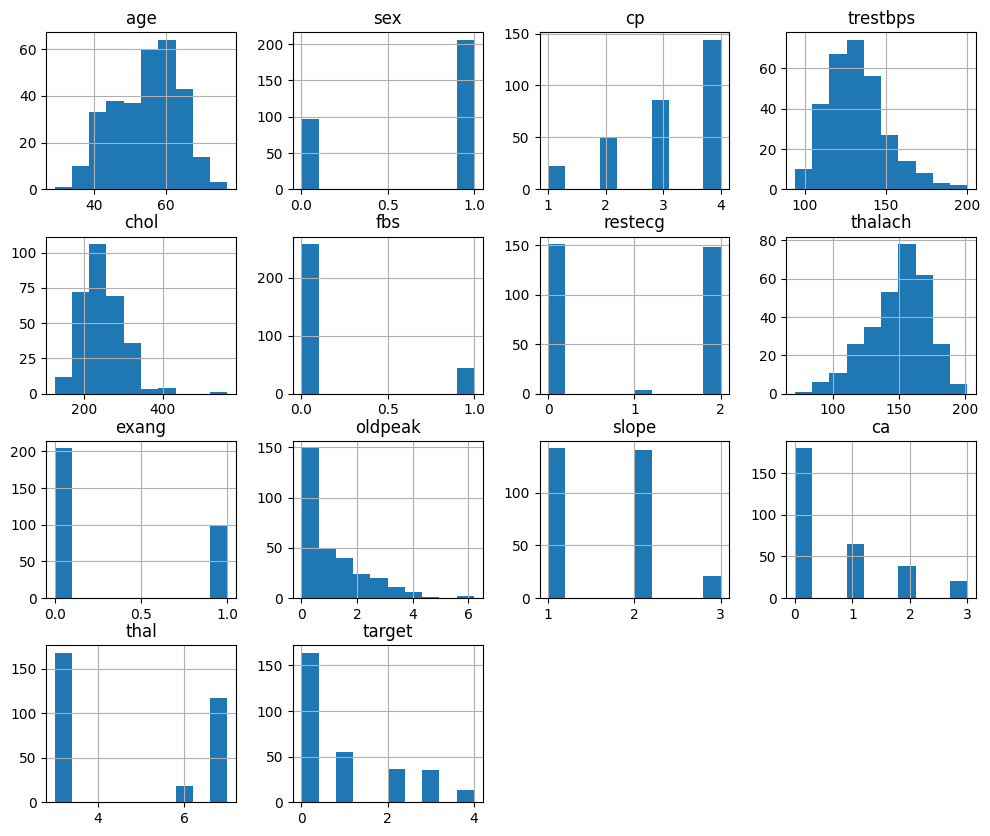

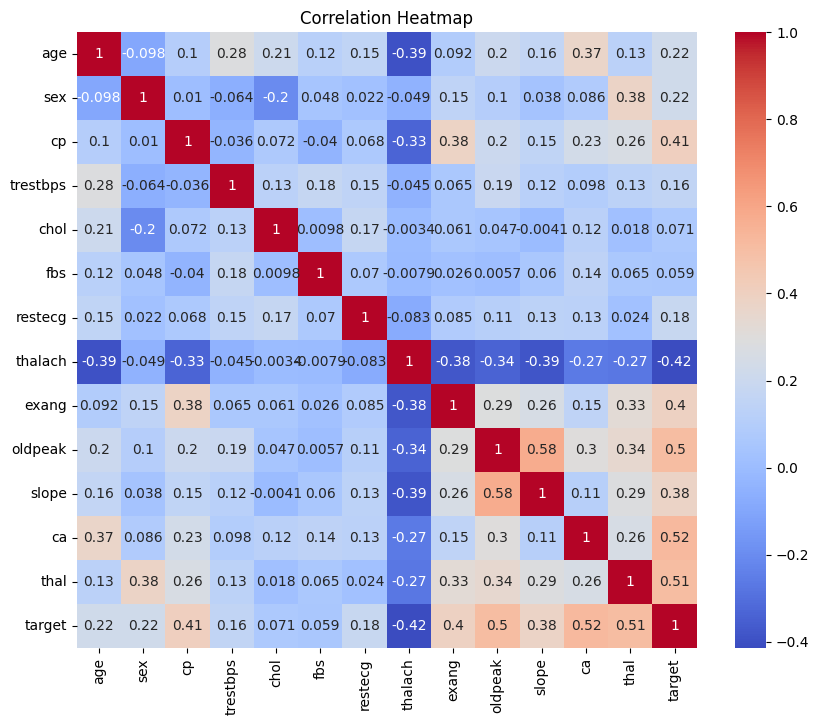

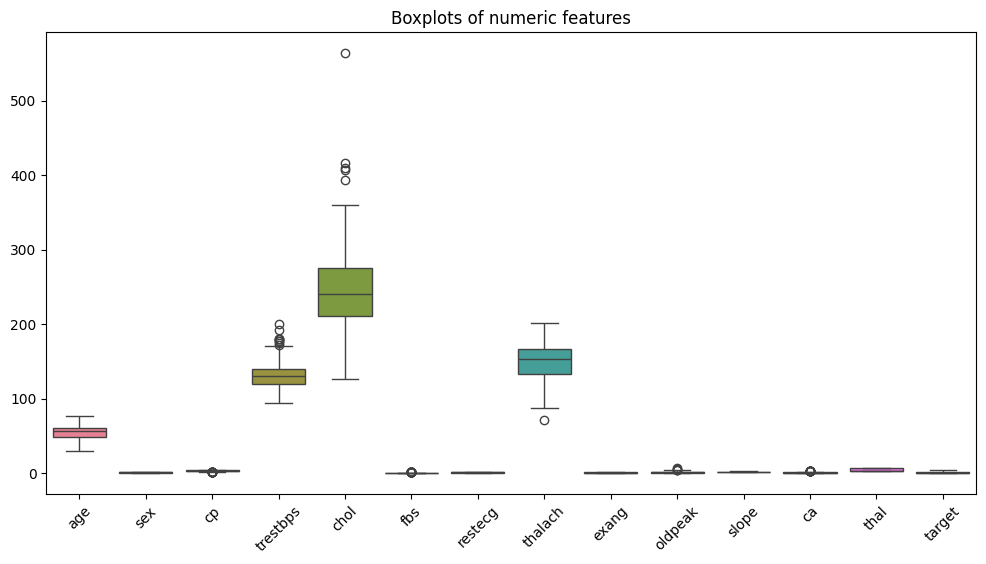

In [13]:
#step 5 EDA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Histograms
df.hist(figsize=(12, 10))
plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# 3. Boxplots
plt.figure(figsize=(12,6))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=45)
plt.title("Boxplots of numeric features")
plt.show()


In [14]:
import os
os.makedirs("data", exist_ok=True)
df_scaled.to_csv("data/cleaned_heart_disease.csv", index=False)
print("✅ Cleaned dataset saved to data/cleaned_heart_disease.csv")


✅ Cleaned dataset saved to data/cleaned_heart_disease.csv
